# 570 Assignment 2-Quanquan Guo
## USC ID: 6502022294

# Part 1

1.Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates. How does your estimate of the treatment effect parameter compare in the following two cases?

In [1]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [2]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

In [3]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import graphviz as gr
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

In [4]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
   
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1
    
    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

## a. Experiments with no covariates in the DGP

### Do not control for any covariate

$y_i = \tau*T_i+e_i$

Example: 

I am a data scientist in the collections team of a commodity company. In order to figure out the impact of sending an email about sales information. My response variable is the amount of sales from the customers.

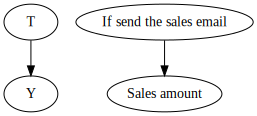

In [5]:
g = gr.Digraph()
g.edge("T", "Y")

g.edge("If send the sales email", "Sales amount")
g

In [6]:
tau = 2
corr = .5
conf=False
p = 10
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████| 495/495 [00:01<00:00, 448.17it/s]


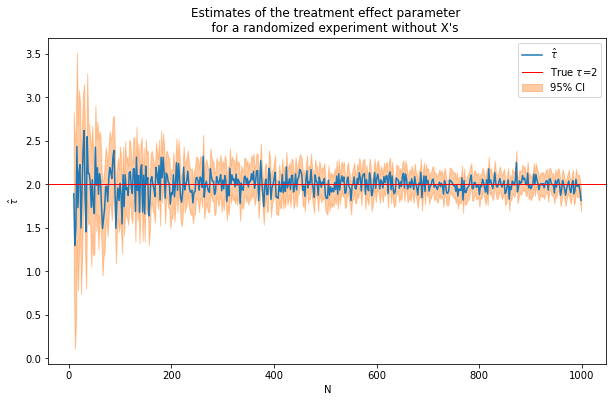

In [7]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without X's"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

### For selected N check that this is the same as running a regression with a intercept

In [8]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [9]:
tauhat,se_tauhat

(2.4099306926892643, 0.20229879470178064)

In [10]:
const = np.ones([N,1])

In [11]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     141.9
Date:                Thu, 14 Apr 2022   Prob (F-statistic):           9.20e-21
Time:                        18:04:21   Log-Likelihood:                -142.03
No. Observations:                 100   AIC:                             288.1
Df Residuals:                      98   BIC:                             293.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4099      0.202     11.913      0.000       2.008       2.811
const         -0.3211      0.143     -2.245      0.027      -0.605      -0.037
==============================================================================
Omnibus:                        4.573   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                2.554
Skew:                          -0.143   Prob(JB):                        0.279
Kurtosis:                       2.271   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
res.params[0], res.HC1_se[0]

(2.4099306926892643, 0.20229879470178064)

### Run R Monte Carlo iterations and compute bias, RMSE and size

In [13]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 187.61it/s]


In [14]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.000648411358207666, RMSE=0.20131671486192496, size=0.0605
N=1000: bias=0.001230602023789345, RMSE=0.0626641660272388, size=0.0515


## b. Experiments with covariates in the DGP

### Control for all the covariates that affect the outcome

$y_i = \tau*T_i+\beta'*x_i+e_i$

Example:

I am a data scientist in the collections team of a commodity company. In order to figure out the impact of sending an email about sales information. My response variable is the amount of sales from the customers.

Now I realize that I need to add some covariates which affect the outcome, so I add age(X1), gender(X2), preference(X3), purchase frequency(X4), membership level(X5) as covariates.

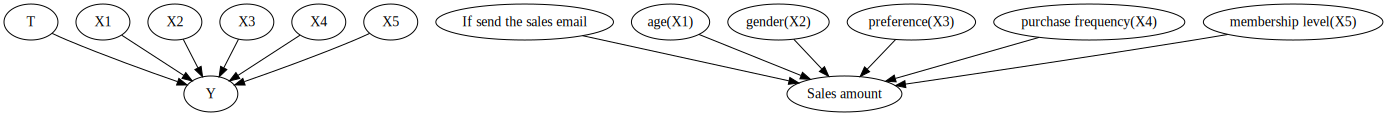

In [15]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X1", "Y")
g.edge("X2", "Y")
g.edge("X3", "Y")
g.edge("X4", "Y")
g.edge("X5", "Y")

g.edge("If send the sales email", "Sales amount")
g.edge("age(X1)", "Sales amount")
g.edge("gender(X2)", "Sales amount")
g.edge("preference(X3)", "Sales amount")
g.edge("purchase frequency(X4)", "Sales amount")
g.edge("membership level(X5)", "Sales amount")

g

In [16]:
tau = 2
corr = .5
conf=False
p = 10
p0 = 5 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_x,tauhats_x,sehats_x,lb_x,ub_x) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████| 495/495 [00:01<00:00, 356.63it/s]


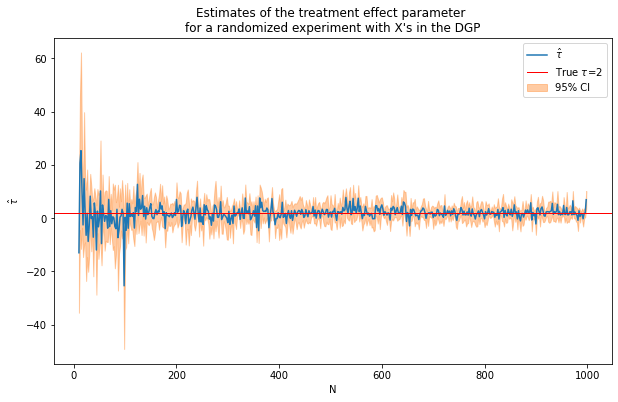

In [17]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP"""
fn_plot_with_ci(nvalues_x,tauhats_x,tau,lb_x,ub_x,caption)

In [18]:
tau = 2
corr = .5
conf=False
p = 10
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_x0,tauhats_x0,sehats_x0,lb_x0,ub_x0) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████| 495/495 [00:01<00:00, 386.80it/s]


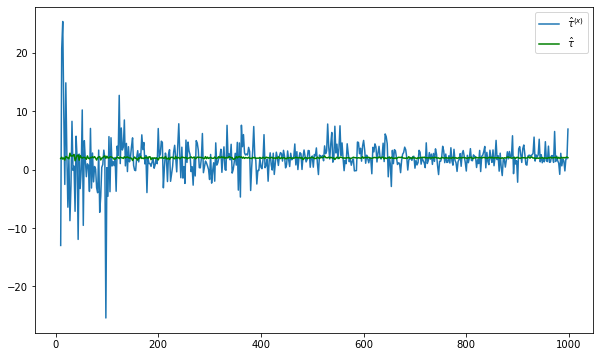

In [19]:
fig = plt.figure(figsize = (10,6))
plt.plot(nvalues_x,tauhats_x,label = '$\hat{\\tau}^{(x)}$')
plt.plot(nvalues_x,tauhats_x0,label = '$\hat{\\tau}$',color = 'green')
plt.legend()

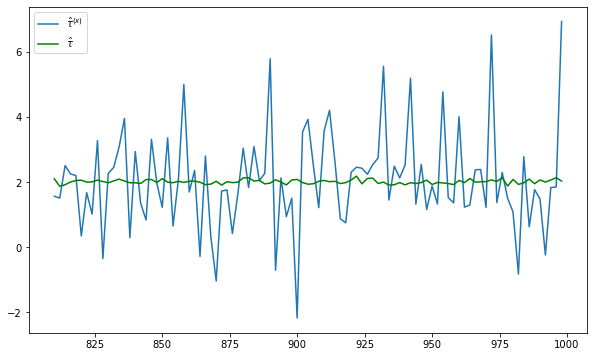

In [20]:
fig = plt.figure(figsize = (10,6))
plt.plot(nvalues_x[400:],tauhats_x[400:],label = '$\hat{\\tau}^{(x)}$')
plt.plot(nvalues_x[400:],tauhats_x0[400:],label = '$\hat{\\tau}$',color = 'green')
plt.legend()

### Repeat experiment with larger N

In [21]:
tau = 2
corr = .5
conf=False
p = 10
p0 = 5 # number of covariates used in the DGP
Nrange = range(1000,50000,10000) # loop over N values
(nvalues_x2,tauhats_x2,sehats_x2,lb_x2,ub_x2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|█████████████████████████████████████████████| 5/5 [00:15<00:00,  3.07s/it]


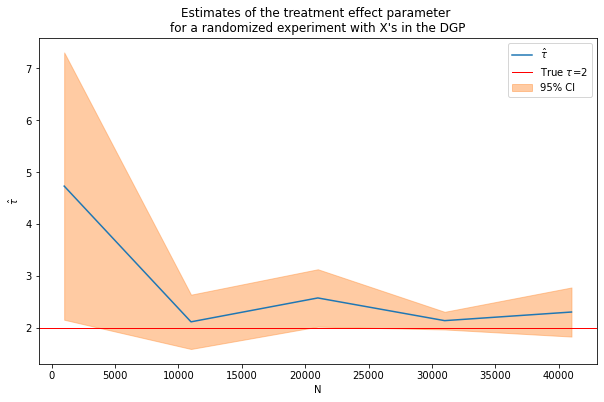

In [22]:
fn_plot_with_ci(nvalues_x2,tauhats_x2,tau,lb_x2,ub_x2,caption)

From the picture, we can see that it still noisy.

### DGP with X - adding covariates to the regression
Use same DGP as before

### 1. if we use some X's that influence the outcome

In [23]:
tau = 2
corr = .5
conf=False
p = 10
p0 = 5 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 1
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|████████████████████████████████████████| 450/450 [00:01<00:00, 321.26it/s]


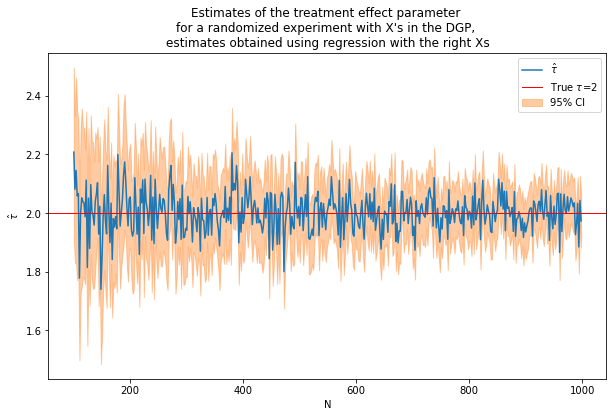

In [24]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP, 
estimates obtained using regression with the right Xs"""
fn_plot_with_ci(nvalues2,tauhats2,tau,lb2,ub2,caption)

### Run R Monte Carlo iterations and compute bias, RMSE and size

In [25]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:11<00:00, 173.12it/s]


In [26]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.05963266708842227, RMSE=4.490384396509541, size=0.052
N=1000: bias=-0.034849133504361106, RMSE=1.4107228288867737, size=0.0555


Including X's improves precision. However, we cheated because we included the right X's from the start.

### 2. if we use some X's that influence the outcome and some that don't

In [27]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 5 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 2
(nvalues3,tauhats3,sehats3,lb3,ub3) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

  0%|                                                   | 0/450 [00:00<?, ?it/s]/var/folders/lq/hlw9rh552x98jrysm95j3gym0000gn/T/ipykernel_1471/2183116843.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Xobs1 = X[:,:np.int(p0/2)]
/var/folders/lq/hlw9rh552x98jrysm95j3gym0000gn/T/ipykernel_1471/2183116843.py:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` o

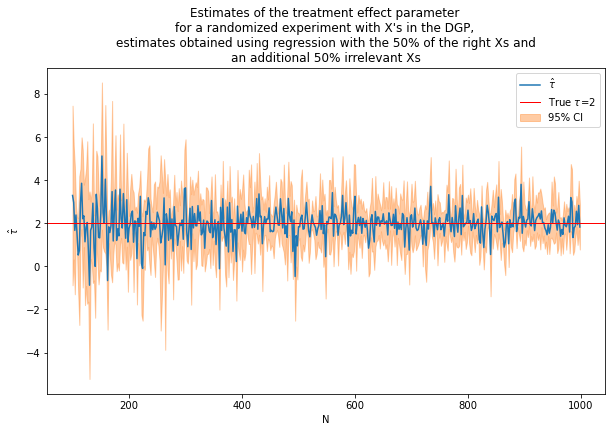

In [28]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP, 
estimates obtained using regression with the 50% of the right Xs and
an additional 50% irrelevant Xs"""
fn_plot_with_ci(nvalues3,tauhats3,tau,lb3,ub3,caption)

### Run R Monte Carlo iterations and compute bias, RMSE and size

In [29]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:27<00:00, 73.17it/s]


In [30]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.11571692807731025, RMSE=4.627809940531529, size=0.0585
N=1000: bias=0.050723729388786686, RMSE=1.4056059701391466, size=0.0485


# Part 2

2.Simulate a DGP with a confounder (common cause)

In [31]:
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from matplotlib import style
import seaborn as sns
import statsmodels.formula.api as smf

style.use("fivethirtyeight")

### First, we simulate DGP with a confounder.

In [32]:
def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

    return Y

In [33]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
   
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1
    
    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        print("flagX: " + flagX)
        print("C: " + C)
        return (Yab,T,C)
    else:
        return (Yab,T,X,C)

### For the following example, I will select only one Yab, one T, one X and one C

In [34]:
tau = 2
corr = .5
conf = True
p = 1
p0 = 1
Nrange = range(10,1000,2)
flagX = 1

# Yab,T,X,C = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
temp_var = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
Yab = temp_var[0]
T = temp_var[1]
if len(temp_var) == 3:
    X = 0
else:
    X = temp_var[2]
C = temp_var[3]

# Yab,T,X,C

## a.You fail to control for the confounder

### Example:

Doctors are studying whether a new surgical plan will accelerate a patient's recovery. Here, the new surgical plan is the treatment, the patient's recovery rate is the dependent variable and gender is the covariate. But the effect of age as a confounder is omitted. Recovery rates vary by age, with older patients healing more slowly. Age also affects willingness to participate in surgery, with younger patients more willing to try new options but older patients wary of the risks.

### In (a) case, we fail to control the confounder.

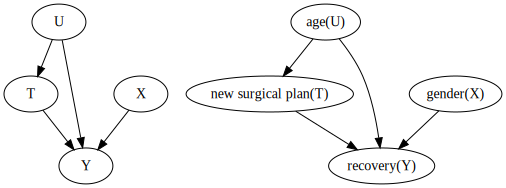

In [35]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("U", "T")
g.edge("U", "Y")
g.edge("X", "Y")

g.edge("new surgical plan(T)", "recovery(Y)")
g.edge("age(U)", "new surgical plan(T)")
g.edge("age(U)", "recovery(Y)")
g.edge("gender(X)", "recovery(Y)")

g

### Original function:
    
$Y = \tau*T + \beta*X + confmult*0.6*C + e$

In [36]:
model_passed_data = {'Yab': Yab, 'T': T, 'X': X, 'C': C}

In [37]:
model = smf.ols(formula='Yab ~ T + X + C',data=model_passed_data)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    Yab   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 1.113e+04
Date:                Thu, 14 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:05:46   Log-Likelihood:                -1409.3
No. Observations:                1000   AIC:                             2827.
Df Residuals:                     996   BIC:                             2846.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0074      0.044     -0.166      0.8

### Run R Monte Carlo iterations and compute bias, RMSE and size

In [38]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yab,T,X,C = fn_generate_data(tau,N,1,1,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:11<00:00, 177.74it/s]


In [39]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-2.1792868400654863, RMSE=6.576134962187723, size=0.0655
N=1000: bias=-1.9944368235540635, RMSE=2.853280999356971, size=0.1665


## b. You do control for the confounder

### Same Example:

Doctors are studying whether a new surgical plan will accelerate a patient's recovery. Here, the new surgical plan is the treatment, the patient's recovery rate is the dependent variable and gender is the covariate. But the effect of age as a confounder is omitted. Recovery rates vary by age, with older patients healing more slowly. Age also affects willingness to participate in surgery, with younger patients more willing to try new options but older patients wary of the risks.

### In (b) case, we do control the confounder. We use the age(U) and gender(X) as the controls

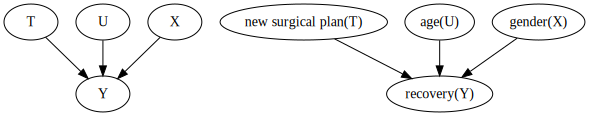

In [40]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("U", "Y")
g.edge("X", "Y")

g.edge("new surgical plan(T)", "recovery(Y)")
g.edge("age(U)", "recovery(Y)")
g.edge("gender(X)", "recovery(Y)")

g

### Second, we plan to set T and C as controls to eliminate the effects of confounder.

Now we resort to partialling out way of breaking regression into 2 steps. 

First, we will regress the treatment T and the outcome Y on the additional controls, C and X. 

Second, we will regress the residual of T on the residuals of Y, both obtained in step 1. 

$Y = \tau*T + a1*X + b1*C + e_y$

$T = a2*X + b2*C + e_t$

In [41]:
model_passed_data = {'Yab': Yab, 'T': T, 'X': X, 'C': C}

In [42]:
model_Yab = smf.ols('Yab ~ X + C',data=model_passed_data).fit()
model_T = smf.ols('T ~ X + C',data=model_passed_data).fit()

residuals = pd.DataFrame(dict(res_Yab=model_Yab.resid, res_T=model_T.resid))

$res_Y = \theta*res_T + u$

In [43]:
model_treatment = smf.ols('res_Yab ~ res_T', data=residuals).fit()

In [44]:
residuals.head()

,res_Yab,res_T
0,-0.070047,0.499612
1,1.034084,0.499499
2,-0.456263,-0.510328
3,1.684582,0.509190
4,1.423053,0.521490


In [45]:
model_2 = sm.OLS(residuals.res_Yab, sm.add_constant(T))
res2 = model_2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                res_Yab   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     1018.
Date:                Thu, 14 Apr 2022   Prob (F-statistic):          1.41e-154
Time:                        18:05:59   Log-Likelihood:                -1411.9
No. Observations:                1000   AIC:                             2828.
Df Residuals:                     998   BIC:                             2838.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0030      0.044    -22.564      0.0

In [46]:
residuals

,res_Yab,res_T
0,-0.070047,0.499612
1,1.034084,0.499499
2,-0.456263,-0.510328
3,1.684582,0.509190
4,1.423053,0.521490
...,...,...
995,-1.533370,-0.573735
996,-0.375793,-0.531691
997,-0.084998,-0.507264
998,0.677878,-0.403834


By regressing Y on X and C and obtaining the residuals for this model, we are creating a new dependent variable with much less variability than the original one.

We can also check that the model that predicts the treatment should not be able to lower the variance of it.

In [47]:
print("Yab Variance", np.var(Yab))
print("Yab Residual Variance", np.var(residuals["res_Yab"]))

print("T Variance", np.var(T))
print("T Residual Variance", np.var(residuals["res_T"]))

model_treatment.summary().tables[1]

Yab Variance 167.40721055625357
Yab Residual Variance 1.9921145963654345
T Variance 0.25
T Residual Variance 0.2480198611735355


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.506e-15,0.031,-4.81e-14,1.000,-0.061,0.061
res_T,2.0221,0.063,32.168,0.000,1.899,2.145


Notice how the variance of Y went from 43.78 to 2.11. We've decreased it a lot once we control for X and C.

### During this process, finally we control the confounding effect and get a fit OLS.

# Part 3

3.Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome)

### Example:

I am a data scientist in the collections team of a commodity company. In order to figure out the impact of sending an email about sales information. My response variable is the amount of sales from the customers.

Now I realize that if the consumer open the email is the selection bias, it will influence the outcome. Because the covarites purchase frequency and membership level both influence open.

## a.Do control the selection bias

### It means that we ignore the open variable, the selection bias will be moved.

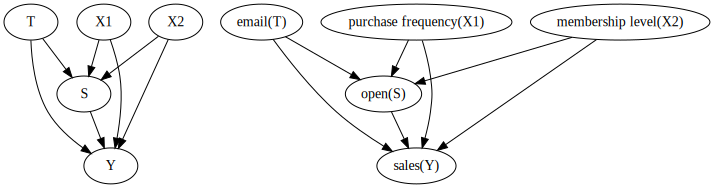

In [48]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("T", "S")
g.edge("S", "Y")
g.edge("X1", "Y")
g.edge("X1", "S")
g.edge("X2", "Y")
g.edge("X2", "S")

g.edge("email(T)", "open(S)")
g.edge("email(T)", "sales(Y)")
g.edge("open(S)", "sales(Y)")
g.edge("purchase frequency(X1)", "open(S)")
g.edge("purchase frequency(X1)", "sales(Y)")
g.edge("membership level(X2)", "open(S)")
g.edge("membership level(X2)", "sales(Y)")


g

### First, simulate DGP

In [49]:
def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

    return Y

In [50]:
def fn_generate_data_new(tau,theta,N,p,p0,corr,flagX = False):
   
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    allX = fn_generate_multnorm(N,corr,nvar)
    X = allX[:,2:] # observed covariates
    T = fn_randomize_treatment(N) # choose treated units
    S = fn_randomize_treatment(N) # choose selection bias units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+theta*S+X@beta0+err
    if flagX==False:
        return (Yab,T,S)
    else:
        return (Yab,T,X,S)

In [51]:
def fn_run_experiments_new(tau,theta,Nrange,p,p0,corr,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T,S = fn_generate_data_new(tau,theta,N,p,p0,corr,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X,S = fn_generate_data_new(tau,theta,N,p,p0,corr,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)

In [52]:
tau = 2
corr = .5
theta = 0
p = 2
p0 = 2
flagX = 1
Nrange = range(10,1000,2) # loop over N values
(nvalues_x3,tauhats_x3,sehats_x3,lb_x3,ub_x3) = fn_run_experiments_new(tau,theta,Nrange,p,p0,corr,flagX)

100%|████████████████████████████████████████| 495/495 [00:02<00:00, 221.59it/s]


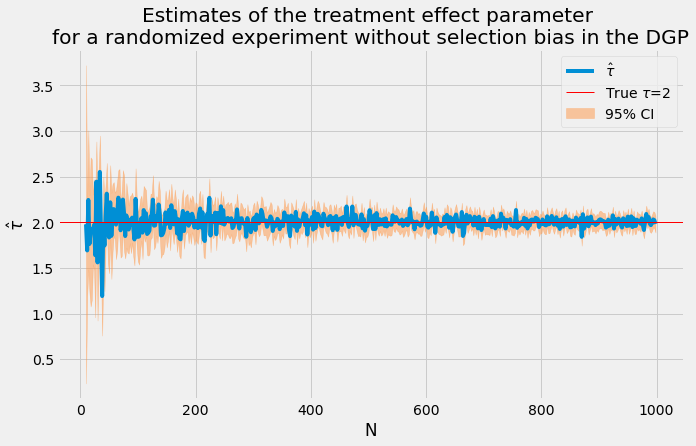

In [53]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment without selection bias in the DGP"""
fn_plot_with_ci(nvalues_x3,tauhats_x3,tau,lb_x3,ub_x3,caption)

### Run R Monte Carlo iterations and compute bias, RMSE and size

In [54]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X,S = fn_generate_data_new(tau,theta,N,p,p0,corr,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:17<00:00, 116.84it/s]


In [55]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.04655580263098941, RMSE=2.216607956741225, size=0.0515
N=1000: bias=0.01233311603200374, RMSE=0.6973177306642293, size=0.045


## b.Fail to control the selection bias.
### Can not ignore the open variable (selection bias). It is still in the regression.

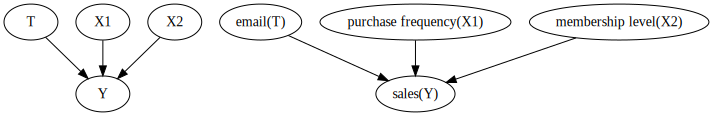

In [56]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X1", "Y")
g.edge("X2", "Y")

g.edge("email(T)", "sales(Y)")
g.edge("purchase frequency(X1)", "sales(Y)")
g.edge("membership level(X2)", "sales(Y)")


g

In [57]:
tau = 2
corr = .5
theta = .7
p = 2
p0 = 2
flagX = 1
(nvalues_x4,tauhats_x4,sehats_x4,lb_x4,ub_x4) = fn_run_experiments_new(tau,theta,Nrange,p,p0,corr,flagX)

100%|████████████████████████████████████████| 495/495 [00:01<00:00, 280.03it/s]


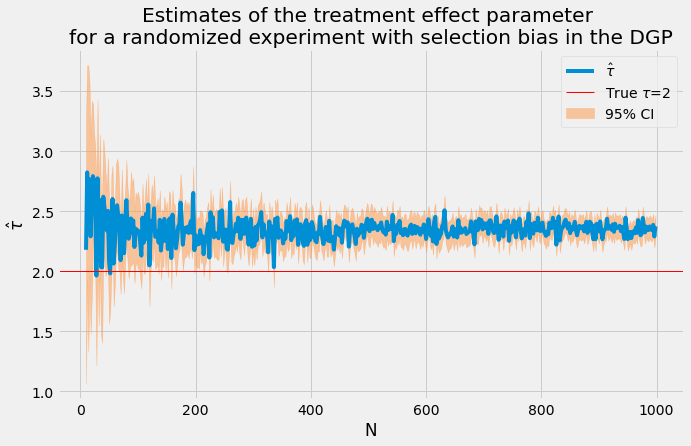

In [58]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with selection bias in the DGP"""
fn_plot_with_ci(nvalues_x4,tauhats_x4,tau,lb_x4,ub_x4,caption)

### Run R Monte Carlo iterations and compute bias, RMSE and size

In [59]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X,S = fn_generate_data_new(tau,theta,N,p,p0,corr,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:16<00:00, 119.27it/s]


In [60]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.0214769676147487, RMSE=2.41287511153908, size=0.058
N=1000: bias=-0.0032788145223040395, RMSE=0.7107409359447983, size=0.0535
